# Reinforcement

使用Policy Gradient算法来解决Cartpole问题

算法流程表示如下
- 初始化策略参数$\theta$
- for 序列 $e = 1 \to E$ do：
    - 用当前策略$\pi_\theta$采样轨迹$\{s_1, a_1, r_1, s_2, a_2, r_2, \dots s_T, a_T, r_T\}$
    - 计算当前轨迹每个时刻$t$往后的回报$\sum_{t'=t}^T \gamma^{t'-t} r_{t'}$，记为$\psi_t$
    - 对$\theta$进行更新，$\theta = \theta + \alpha \sum_t^T \psi_t \nabla_\theta \log \pi_\theta(a_t|s_t)$
- end for

In [1]:
import gymnasium as gym
import torch
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
#import rl_utils

## Part one

首先需要定义Policy Net（拟合策略网络），输入是状态 S ，输出是当前状态下的动作概率分布

使用torch.nn模块来实现神经网络的定义

In [2]:
class PolicyNet(torch.nn.Module):
    def __init__(self, state_dim, hidden_dim, action_dim):
        super(PolicyNet, self).__init__()
        self.fc1 = torch.nn.Linear(state_dim, hidden_dim)
        self.fc2 = torch.nn.Linear(hidden_dim, action_dim)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)

In [ ]:
class REINFORCE:
    def __init__(self, state_dim, hidden_dim, action_dim,learning_rate, gamma, device):
        self.policy_net = PolicyNet(state_dim, hidden_dim, action_dim).to(device)
        self.optimizer = torch.optim.Adam(self.policy_net.parameters(),lr = learning_rate)
        self.gamma = gamma
        self.device = device

    def take_action(self, state):
        state = torch.tensor([state], dtype = torch.float).to(self.device)
        probs = self.policy_net(state)
        action_dist = torch.distributions.Categorical(probs)
        action = action_dist.sample()
        return action.item()
    
    def update(self, transition_dict):
        reward_list = transition_#dict['rewards']
        state_list = transition_dict['states']
        action_list = transition_dict['actions']

        G = 0
        self.optimizer.zero_grad()
        for i in reversed(range(len(reward_list))):
            reward = reward_list[i]
            state = torch.tensor([state_list[i]],dtype = torch.float).to(self.device)
            action = torch.tensor([action_list[i]]).view(-1,1).to(self.device)
            log_prob = torch.log(self.policy_net(state).gather(1, action))
            G = self.gamma * G + reward
            loss = -log_prob * G
            loss.backward()

        self.optimizer.step()

In [10]:
learning_rate = 1e-3
num_episodes = 2000
hidden_dim = 128
gamma = 0.98
device = torch.device('cuda') if torch.cuda.is_available() else torch.device("cpu")
env_name = "CartPole-v0"
env = gym.make(env_name)

torch.manual_seed(0)

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n
agent = REINFORCE(state_dim, hidden_dim, action_dim, learning_rate, gamma, device)

return_list = []

for i in range(10):
    with tqdm(total = int(num_episodes / 10), desc = 'Iteration %d' % i) as pbar:
        for i_episode in range(int(num_episodes / 10)):
            episode_return = 0
            transition_dict = {
                'states': [],
                'actions': [],
                'next_states':[],
                'rewards': [],
                'dones':[]
            }
            state, _ = env.reset()
            done = False
            while not done:
                action = agent.take_action(state)
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                transition_dict['states'].append(state)
                transition_dict['actions'].append(action)
                transition_dict['next_states'].append(next_state)
                transition_dict['rewards'].append(reward)
                transition_dict['dones'].append(done)
                state = next_state
                episode_return += reward
            return_list.append(episode_return)
            agent.update(transition_dict)
            if (i_episode + 1) % 10 == 0:
                pbar.set_postfix({
                    'episode':
                    '%d' % (num_episodes / 10 * i + i_episode + 1),
                    'return':
                    '%.3f' % np.mean(return_list[-10:])
                })
            pbar.update(1)

/Users/crazybread/miniconda3/envs/rl/lib/python3.10/site-packages/gymnasium/envs/registration.py:512: DeprecationWarning: WARN: The environment CartPole-v0 is out of date. You should consider upgrading to version `v1`.
  logger.deprecation(
Iteration 9: 100%|██████████| 200/200 [00:05<00:00, 36.67it/s, episode=2000, return=187.100]


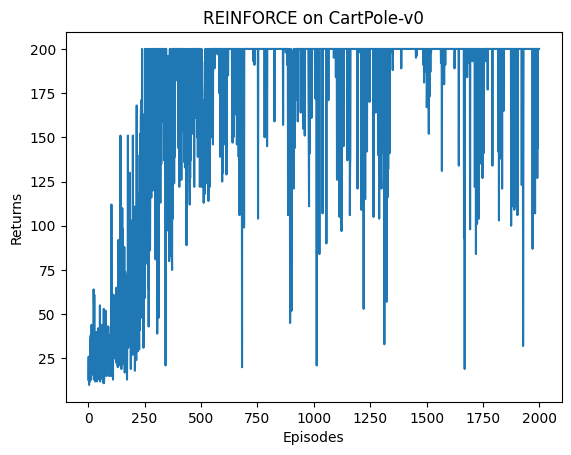

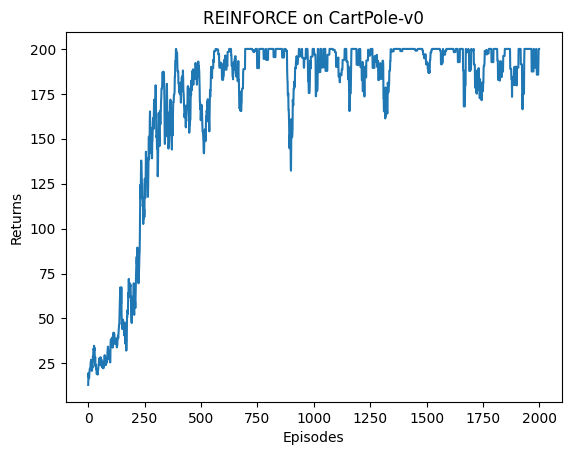

In [11]:
import rl_utils
episodes_list = list(range(len(return_list)))
plt.plot(episodes_list, return_list)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

mv_return = rl_utils.moving_average(return_list, 9)
plt.plot(episodes_list, mv_return)
plt.xlabel('Episodes')
plt.ylabel('Returns')
plt.title('REINFORCE on {}'.format(env_name))
plt.show()

In [ ]:
# test agent
def test_agent(agent, n_episodes=10):
    env = gym.make(env_name,render_mode='human')
    returns = []
    for _ in range(n_episodes):
        state, _ = env.reset()
        done = False
        ep_return = 0.0
        while not done:
            action = agent.take_action(state)
            next_state, reward, terminated, truncated, _ = env.step(action)
            done = terminated or truncated
            ep_return += reward
            state = next_state
        returns.append(ep_return)
        
    env.close()

In [1]:
test_agent(agent,5)

NameError: name 'test_agent' is not defined